In [1]:
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Activation, Embedding
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad
from matplotlib import pyplot as plt

In [2]:
# Load Training und Val Data
with open('FormatedData/E100000/x_train.pickle', 'rb') as file:
    x_train = pickle.load(file)
with open('FormatedData/E100000/x_val.pickle', 'rb') as file:
    x_val = pickle.load(file)
with open('FormatedData/E100000/y_train.pickle', 'rb') as file:
    y_train = pickle.load(file)
with open('FormatedData/E100000/y_val.pickle', 'rb') as file:
    y_val = pickle.load(file)
print(len(x_train))
print(len(x_val))
print(len(y_train))
print(len(y_val))

95000
5000
95000
5000


In [3]:
with open('FormatedData/E100000/Metadata/context_words.pickle', 'rb') as file:
    context_words = pickle.load(file)
with open('FormatedData/E100000/Metadata/total_unique_words.pickle', 'rb') as file:
    total_unique_words = pickle.load(file)
with open('FormatedData/E100000/Metadata/embeddings_matrix.pickle', 'rb') as file:
    embeddings_matrix = pickle.load(file)

In [4]:
# Metrics
def top_5_categorical_accuracy(y_true, y_pred):
    return keras.metrics.SparseTopKCategoricalAccuracy(y_true, y_pred, k=5)
def top_10_categorical_accuracy(y_true, y_pred):
    return keras.metrics.SparseTopKCategoricalAccuracy(y_true, y_pred, k=10)
# Activation Functions
def elliott_activation(x):
    return (0.5 * x / (1 + tf.abs(x))) + 0.5
def modified_elliott_activation(x):
    return (x / tf.sqrt(1 + tf.square(x))) + 0.5

In [5]:
dropout=.5
keras.backend.clear_session()
# Create Model
model = Sequential()
model.add(Embedding(input_dim=total_unique_words, output_dim=100, input_length=context_words, weights=[embeddings_matrix], trainable=False))
model.add(LSTM(128, return_sequences=True, recurrent_dropout=dropout,  dropout=dropout, activation="softsign"))
model.add(LSTM(128, recurrent_dropout=dropout, dropout=dropout, activation="softsign"))
model.add(Dense(total_unique_words, activation="softmax"))

In [6]:
# Train Model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adagrad(learning_rate=1), metrics=['accuracy', SparseTopKCategoricalAccuracy(k=5)])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=128, epochs=50, shuffle=True).history

Epoch 1/50
743/743 [==============================] - 51s 63ms/step - loss: 6.8779 - accuracy: 0.0552 - sparse_top_k_categorical_accuracy: 0.1584 - val_loss: 6.7134 - val_accuracy: 0.0554 - val_sparse_top_k_categorical_accuracy: 0.1360
Epoch 2/50
743/743 [==============================] - 46s 61ms/step - loss: 6.5130 - accuracy: 0.0734 - sparse_top_k_categorical_accuracy: 0.1880 - val_loss: 6.4561 - val_accuracy: 0.0638 - val_sparse_top_k_categorical_accuracy: 0.2034
Epoch 3/50
743/743 [==============================] - 45s 61ms/step - loss: 6.3158 - accuracy: 0.0831 - sparse_top_k_categorical_accuracy: 0.2072 - val_loss: 6.3714 - val_accuracy: 0.0796 - val_sparse_top_k_categorical_accuracy: 0.2176
Epoch 4/50
743/743 [==============================] - 46s 62ms/step - loss: 6.1746 - accuracy: 0.0922 - sparse_top_k_categorical_accuracy: 0.2214 - val_loss: 6.2890 - val_accuracy: 0.0878 - val_sparse_top_k_categorical_accuracy: 0.2302
Epoch 5/50
743/743 [==============================] - 45

In [7]:
# Save Model and history
model.save('IModels/IModel0/Model_100000.h5')
pickle.dump(history, open("Models/Model0/history.p", "wb"))

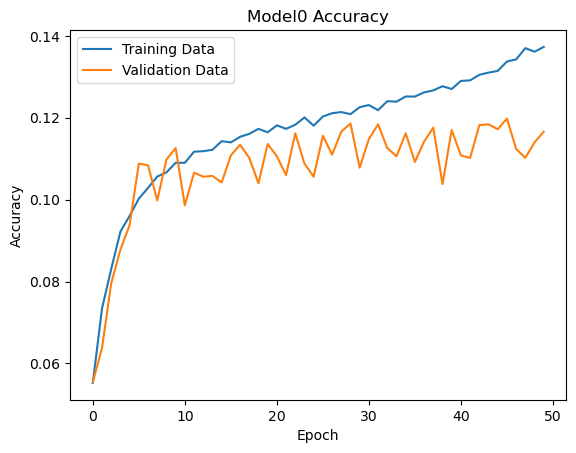

In [8]:
# Get Model stats
# model = load_model('Model0/Model_100000.h5')
history = pickle.load(open("IModels/IModel0/history.p", "rb"))

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('IModel0 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Data', 'Validation Data'], loc='upper left') 

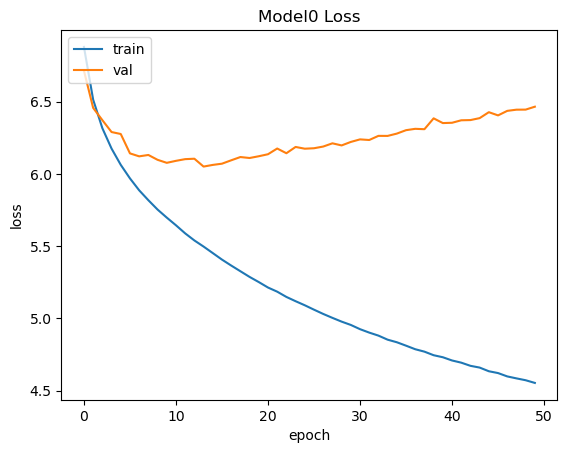

In [9]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model0 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [10]:
# Registriere die benutzerdefinierten Metrikfunktionen
custom_objects = {'top_5_categorical_accuracy': top_5_categorical_accuracy,
                  'top_10_categorical_accuracy': top_10_categorical_accuracy,
                 'elliott_activation': elliott_activation,
                 'modified_elliott_activation': modified_elliott_activation}

# Lade das Modell mit den registrierten benutzerdefinierten Metriken
with tf.keras.utils.custom_object_scope(custom_objects):
    model = load_model('IModels/Model0/Model_100000.h5')